In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer as WNL
%matplotlib inline

In [ ]:
# Defining data directory
data_dir = os.getcwd() + '/../'
# Check in contents of current dir are same as expected
os.listdir(data_dir)

In [3]:
# Loading data 
train_data = pd.read_json(data_dir + 'stackoverflow-data-idf.json', lines = True)
test_data = pd.read_json(data_dir + 'stackoverflow-test.json', lines = True)

In [4]:
print("Schema:\n\n",train_data.dtypes)
print("Number of questions,columns=",train_data.shape)

Schema:

 accepted_answer_id          float64
answer_count                  int64
body                         object
comment_count                 int64
community_owned_date         object
creation_date                object
favorite_count              float64
id                            int64
last_activity_date           object
last_edit_date               object
last_editor_display_name     object
last_editor_user_id         float64
owner_display_name           object
owner_user_id               float64
post_type_id                  int64
score                         int64
tags                         object
title                        object
view_count                    int64
dtype: object
Number of questions,columns= (20000, 19)


In [5]:
# preprocessing only required data...
class preprocessor:
    
    def __init__(self):
        
        self.lemmatizer = WNL()
        self.TAG_RE = re.compile(r'<[^>]+>')
    
    def normalize_text(self, s):
        lower_s = self.lower(s)
        rem_p_s = self.remove_punc(lower_s)
        rem_a_s = self.remove_articles(rem_p_s)
        space_s = self.white_space_fix(rem_a_s)
        lemma_s = self.lemmatize(space_s)
        return lemma_s
        
    def lemmatize(self, txt):
        lemmatizer = self.lemmatizer
        return ' '.join(lemmatizer.lemmatize(lemmatizer.lemmatize(word, pos = 'v'), pos = 'v') for word in txt.split())

    def remove_articles(self, text):
        return re.sub('\s+(a|an|and|the)(\s+)', ' ',text)

    def white_space_fix(self, text):
        return ' '.join(text.split())

    def remove_punc(self, text):
        translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))
        return text.translate(translator)

    def lower(self, text):
        return text.lower()
    
    def pre_process(self, text):

        # remove html tags
        text = self.TAG_RE.sub(' ', text)

        # remove special characters and digits
        text=re.sub("(\\d|\\W)+"," ",text)

        return self.normalize_text(text)
    
PRE = preprocessor()

In [6]:
train_data['text'] = train_data['title'] + train_data['body']
train_data['text'] = train_data['text'].apply(lambda x:PRE.pre_process(x))

In [7]:
# Sneak peakkk.....
train_data['text'][np.random.randint(train_data.shape[0])]

'abnormal width of columns i be try to create design use bootstrap which have fix top navbar columns below that first column have fix top div with full parent width more content beneath it which can scroll fix div navbar cant second column have image which cover whole column nothing more i have do follow lt nav class navbar navbar default navbar fix top black gt lt div class container fluid gt lt brand toggle get group for better mobile display gt lt div class navbar header gt lt button type button class navbar toggle collapse data toggle collapse data target bs example navbar collapse aria expand false gt lt span class sr only gt toggle navigation lt span gt lt span class icon bar gt lt span gt lt span class icon bar gt lt span gt lt span class icon bar gt lt span gt lt button gt lt class navbar brand href gt owol lt gt lt div gt lt collect nav link form other content for toggle gt lt div class collapse navbar collapse id bs example navbar collapse gt lt ul class nav navbar nav navbar

In [8]:
# creating documents corpus 
corpus = pd.DataFrame(train_data['text'])

In [9]:
corpus.head()

,text
0,serialize private struct can it be do i have p...
1,how do i prevent float right content from over...
2,gradle command line i m try to run shell scrip...
3,loop variable as parameter in asynchronous fun...
4,canot get href value hi i need to valid href b...


In [10]:
corpus.to_csv('train_corpus')

In [11]:
### Enough Preprocessing Now TF IDF Stuff....

In [26]:
class tfidf:
    
    def __init__(self, corpus):
        
        self.corpus = list(corpus['text'])
        self.tfidfmat = None
        self.n_docs = corpus.shape[0]
        self.tfmat = None
        self.idfvec = None
        self.word_indices = {}
        self.doc_indices = {}
        
        
    def gen_mats(self):
        
        count_wor = 0
        for doc in self.corpus:
            for word in doc.strip().split():
                if(word not in self.word_indices.keys()):
                    self.word_indices[word] = count_wor
                    count_wor += 1
                else:
                    pass
                
        self.n_words = len(self.word_indices.keys())
        self.tfmat = np.zeros((self.n_words, self.n_docs))
        self.idfvec = np.zeros((self.n_words))
        self.tfidfmat = np.zeros((self.n_words, self.n_docs))
#         print('Done 1')
        for i in range(len(self.corpus)):
            doc = self.corpus[i]
            for word in doc.strip().split():
                index = self.word_indices[word]
                self.tfmat[index, i] += 1
                
        self.tfmat = self.tfmat/np.sum(self.tfmat, axis = 0)
        
        dft = np.sum(1*(self.tfmat > 0), axis = 1)
        self.idfvec = np.log(np.divide(self.n_docs, dft))
        
        self.tfidfmat = np.multiply(self.tfmat,self.idfvec.reshape([-1,1]))

In [27]:
model = tfidf(corpus.iloc[0:500])

In [28]:
model.gen_mats()

In [29]:
model.n_words

6882

In [32]:
model.tfidfmat.shape

(6882, 500)

In [33]:
X = model.tfidfmat.T

In [35]:
X.shape

(500, 6882)

In [82]:
# we will plot these 500 documents and see the plots but first we need tsne
from sklearn.manifold import TSNE as tsne
from sklearn.decomposition import PCA

In [117]:
reductor = tsne(n_components = 2)

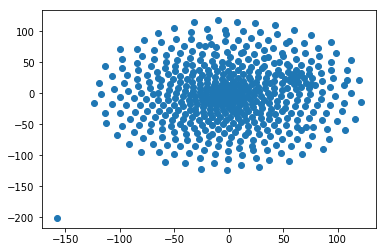

In [118]:
X_reduced  = reductor.fit_transform(X)
plt.scatter(X_reduced[:,0], X_reduced[:,1])

In [119]:
from sklearn.feature_extraction.text import TfidfVectorizer as tfidf

In [120]:
model_sk = tfidf()

In [121]:
X_sk = model_sk.fit_transform(list(corpus.iloc[0:500]['text'])).todense()

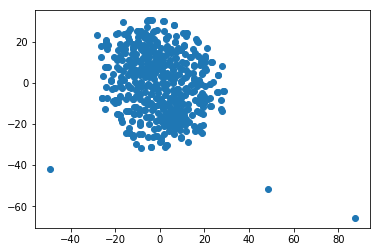

In [122]:
X_reduced  = reductor.fit_transform(X_sk)
plt.scatter(X_reduced[:,0], X_reduced[:,1])